In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

from string import ascii_uppercase

## 1) Carregando imagens

In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png"):
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    images.append(img)
                    labels.append(label)
    return images, labels

## 2) Construindo rede própria

In [6]:
def simple_CNN_model(input_shape = (64, 64, 3), num_classes = 21):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
    return model

### 2.1) Pré-processando dados

In [7]:
label_encoder = LabelEncoder()
X_train, y_train = load_images_from_folder('libras_dataset/train')
X_test, y_test = load_images_from_folder('libras_dataset/test')
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train, num_classes=21)
y_test_one_hot = to_categorical(y_test, num_classes=21)

In [8]:
print(X_train.shape)
print(X_train[0].shape)
print(set(y_train))

(34714, 64, 64, 3)
(64, 64, 3)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


### 2.2) Treinamento do modelo

In [10]:
model = simple_CNN_model()
history = model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

### 2.4) Avaliando treinamento do modelo

{'loss': [0.8306015133857727, 0.1339048594236374, 0.08333085477352142, 0.05055518448352814, 0.040250979363918304, 0.0374310128390789, 0.02810302935540676, 0.026243027299642563, 0.020968610420823097, 0.02100110426545143], 'accuracy': [0.7346152663230896, 0.95477294921875, 0.9725973010063171, 0.9831118583679199, 0.9861006140708923, 0.9879730939865112, 0.991213858127594, 0.9910337924957275, 0.9931943416595459, 0.993446409702301], 'val_loss': [38.12940216064453, 45.16492462158203, 44.01249313354492, 54.7808952331543, 51.30377197265625, 45.23100280761719, 40.8321647644043, 46.56769561767578, 63.4053955078125, 50.04825973510742], 'val_accuracy': [0.007921647280454636, 0.007057467941194773, 0.006337318103760481, 0.006337318103760481, 0.006337318103760481, 0.006337318103760481, 0.006337318103760481, 0.006337318103760481, 0.006913437973707914, 0.006337318103760481]}


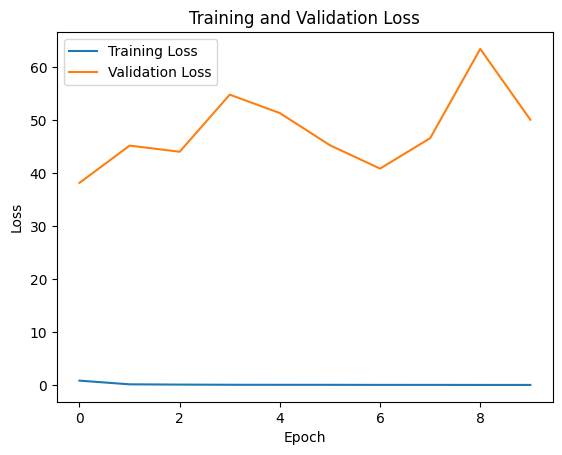

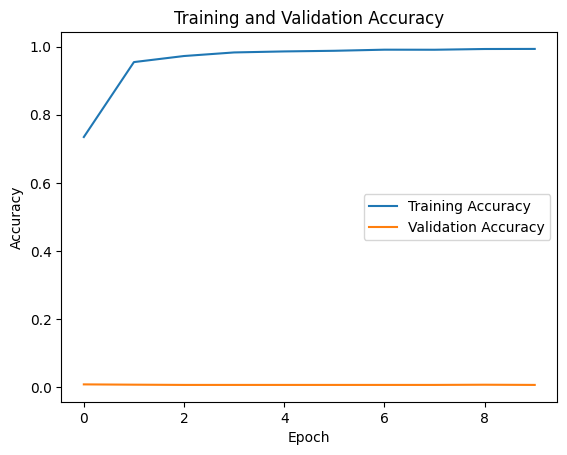

In [16]:
# Plotar o gráfico de Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar o gráfico de Acurácia
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.5) Teste do modelo

In [23]:
predictions = model.predict(X_test)

# Converter as probabilidades de volta para rótulos de classe usando np.argmax
predicted_labels = np.argmax(predictions, axis=1)

# Converter rótulos one-hot-encoded para rótulos de classe
y_test_classes = np.argmax(y_test_one_hot, axis=1)

361/361 [==============================] - 4s 11ms/step


### 2.5) Avaliando teste do modelo

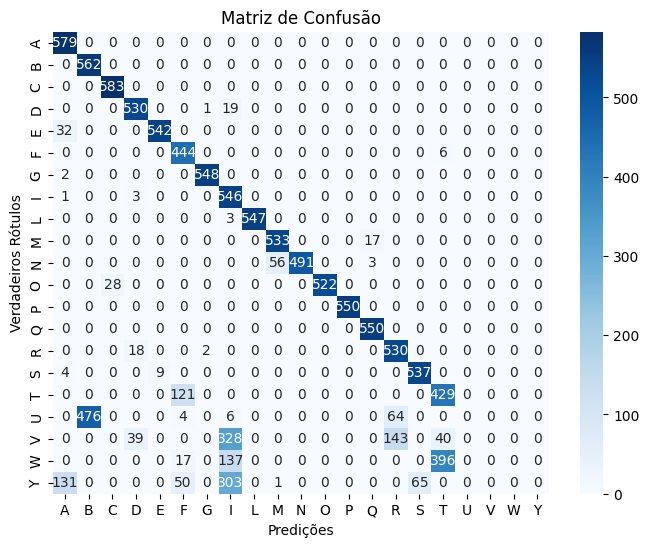

In [25]:
# Definir classes (letras do alfabeto, excluindo H, J, K, X e Z)
classes = [letter for letter in ascii_uppercase if letter not in {'H', 'J', 'K', 'X', 'Z'}]

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, predicted_labels)

# Exibir a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão')
plt.xlabel('Predições')
plt.ylabel('Verdadeiros Rótulos')
plt.show()

## 3) Rede com ViT

In [23]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [25]:
# Carregar o extrator de características ViT
feature_extractor = ViTFeatureExtractor(model_name="google/vit-base-patch16-224")

# Pré-processar os dados
X_train_features = feature_extractor(X_train, return_tensors="tf", padding=True, truncation=True)
X_test_features = feature_extractor(X_test, return_tensors="tf", padding=True, truncation=True)

MemoryError: Unable to allocate 588. KiB for an array with shape (224, 224, 3) and data type float32

In [ ]:
print("Entrou")

# Criar o modelo ViT para classificação de imagem
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

print("Saiu")

# model.trainable = True

# Substitua a camada de classificação por uma nova camada para o número de classes desejado
num_classes = 21  # ajuste conforme o número de classes dos sinais de Libras
vit_model_ext = tf.keras.Sequential([
    vit_model,
    layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
vit_model_ext.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

vit_model_ext.summary()

In [ ]:
# Treinar o modelo
vit_model_ext.fit(X_train_features, y_train_one_hot, epochs=5, batch_size=32, validation_data=(X_test_features, y_test))

In [ ]:
# Avaliar o modelo
accuracy = model.evaluate(X_test_features, y_test)[1]
print(f"Acurácia do modelo: {accuracy}")